In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import numpy as np
from numba import jit
plt.style.use(['science','nature','notebook'])

In [ ]:
@jit
def init(L):
        state = 2 * np.random.randint(2, size=(L,L)) - 1
        return state
        
config = init(16)

In [3]:
@jit
def E_dimensionless(config,L):
    total_energy = 0
    for i in range(len(config)):
        for j in range(len(config)):
            S = config[i,j]
            nb = config[(i+1)%L, j] + config[i, (j+1)%L] + config[(i-1)%L, j] + config[i, (j-1)%L]
            total_energy += -nb * S
    return (total_energy/4)

@jit
def magnetization(config):
    Mag = np.sum(config)
    return Mag

In [4]:
@jit
def MC_step(config, beta):
    '''Monte Carlo move using Metropolis algorithm '''
    L = len(config)
    for i in range(L):
        for j in range(L):
            a = np.random.randint(0, L) # looping over i & j therefore use a & b
            b = np.random.randint(0, L)
            sigma =  config[a, b]
            neighbors = config[(a+1)%L, b] + config[a, (b+1)%L] + config[(a-1)%L, b] + config[a, (b-1)%L]
            del_E = 2*sigma*neighbors
            if del_E < 0:
                sigma *= -1
            elif np.random.rand() < np.exp(-del_E*beta):
                sigma *= -1
            config[a, b] = sigma
    return config

In [5]:
@jit
def calcul_energy_mag_C_X(config, L, eqSteps, err_runs):
        
    # L is the length of the lattice
        
    nt      = 1000         #  number of temperature points
    mcSteps = 5000
    
    T_c = 2/np.log(1 + np.sqrt(2))
        
    # the number of MC sweeps for equilibrium should be at least equal to the number of MC sweeps for equilibrium

    # initialization of all variables
    T = np.linspace(1., 7., nt); 
    E,M,C,X = np.zeros(nt), np.zeros(nt), np.zeros(nt), np.zeros(nt)
    C_theoric, M_theoric = np.zeros(nt), np.zeros(nt)
    delta_E, delta_M, delta_C, delta_X = np.zeros(nt), np.zeros(nt), np.zeros(nt), np.zeros(nt)
    n1 = 1.0/(mcSteps*L*L)
    n2 = 1.0/(mcSteps*mcSteps*L*L)    # n1 and n2 will be use to compute the mean value and the # by sites
        # of E and E^2
        
    Energies = []
    Magnetizations = []
    SpecificHeats = []
    Susceptibilities = []
    delEnergies = []
    delMagnetizations = []
    delSpecificHeats = []
    delSusceptibilities = []
    
    for t in range(nt):
        # initialize total energy and mag
        beta = 1./T[t]
        # evolve the system to equilibrium
        for i in range(eqSteps):
            MC_step(config, beta)
        # list of ten macroscopic properties
        Ez = []
        Cz = [] 
        Mz = []
        Xz = [] 

        for j in range(err_runs):
            E = E_squared = M = M_squared = 0
            for i in range(mcSteps):
                MC_step(config, beta)           
                energy = E_dimensionless(config,L) # calculate the energy at time stamp
                mag = abs(magnetization(config)) # calculate the abs total mag. at time stamp

                # sum up total energy and mag after each time steps

                E += energy
                E_squared += energy**2
                M += mag
                M_squared += mag**2


            # mean (divide by total time steps)

            E_mean = E/mcSteps
            E_squared_mean = E_squared/mcSteps
            M_mean = M/mcSteps
            M_squared_mean = M_squared/mcSteps

            # calculate macroscopic properties (divide by # sites) and append

            Energy = E_mean/(L**2)
            SpecificHeat = beta**2 * (E_squared_mean - E_mean**2)/L**2
            Magnetization = M_mean/L**2
            Susceptibility = beta * (M_squared_mean - M_mean**2)/(L**2)
            
            Ez.append(Energy)
            Cz.append(SpecificHeat)
            Mz.append(Magnetization)
            Xz.append(Susceptibility)

        Energy = np.mean(Ez)
        Energies.append(Energy)
        delEnergy = np.std(Ez)
        delEnergies.append(float(delEnergy))
        
        Magnetization = np.mean(Mz)
        Magnetizations.append(Magnetization)
        delMagnetization = np.std(Mz)
        delMagnetizations.append(delMagnetization)

        
        SpecificHeat = np.mean(Cz)
        SpecificHeats.append(SpecificHeat)
        delSpecificHeat = np.std(Cz)
        delSpecificHeats.append(delSpecificHeat)

        Susceptibility = np.mean(Xz)
        delSusceptibility = np.std(Xz)        
        Susceptibilities.append(Susceptibility)
        delSusceptibilities.append(delSusceptibility)
        
        if T[t] - T_c >= 0:
            C_theoric[t] = 0
        else:
            M_theoric[t] = pow(1 - pow(np.sinh(2*beta), -4),1/8)
        
        coeff = np.log(1 + np.sqrt(2))
        if T[t] - T_c >= 0:
            C_theoric[t] = 0
        else: 
            C_theoric[t] = (2.0/np.pi) * (coeff**2) * (-np.log(1-T[t]/T_c) + np.log(1.0/coeff) - (1 + np.pi/4)) 
        
    return T, Energies, Magnetizations, SpecificHeats, Susceptibilities, delEnergies, delMagnetizations, M_theoric, C_theoric, delSpecificHeats, delSusceptibilities

In [ ]:
all = calcul_energy_mag_C_X(config, 16, 10000, 10)

In [ ]:
T = all[0]
Energies = all[1]
Magnetizations= all[2]
SpecificHeats= all[3]
Susceptibilities= all[4]
delEnergies = all[5]
delMagnetizations= all[6]
M_theoric= all[7]
C_theoric= all[8]
delSpecificHeats= all[9]
delSusceptibilities= all[10]

Text(0.5, 1.0, 'delSusceptibilities')

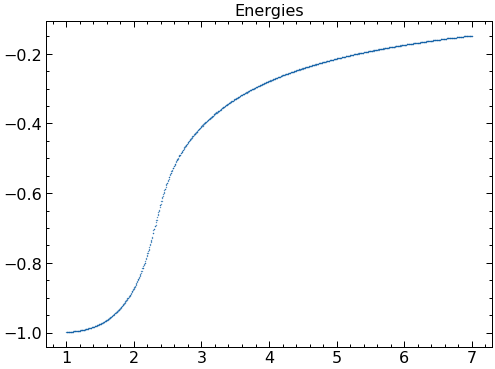

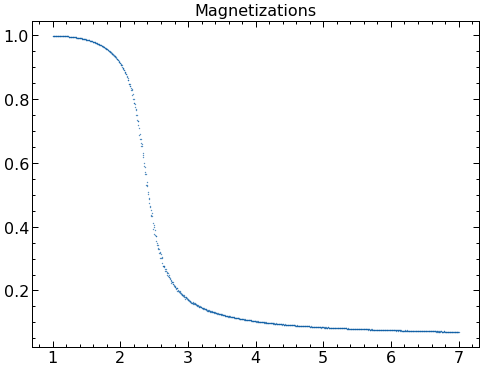

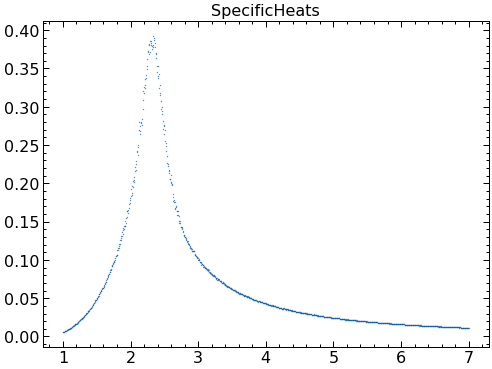

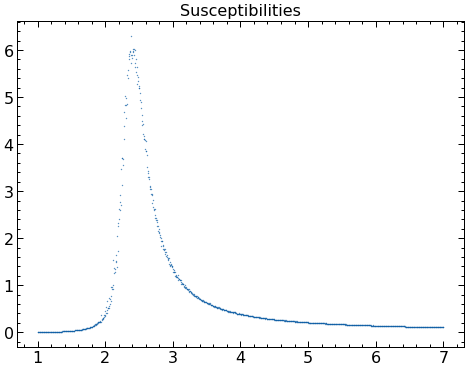

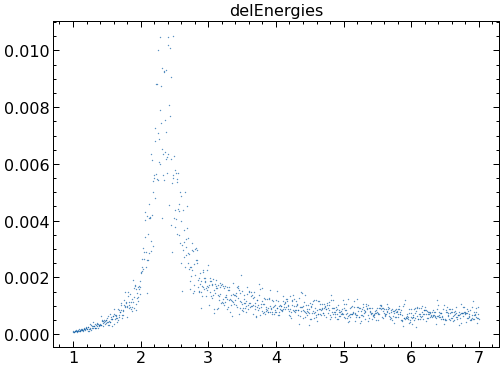

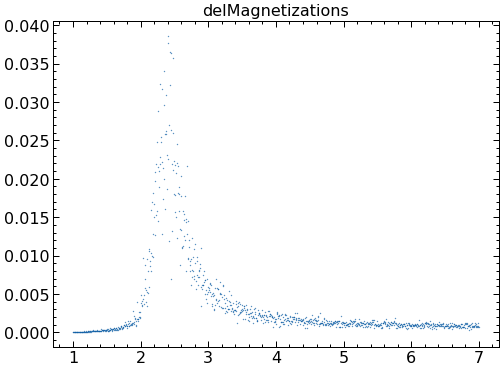

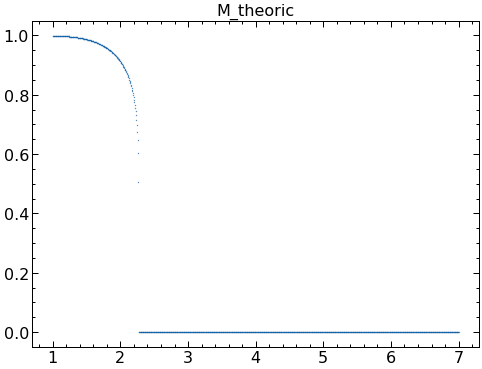

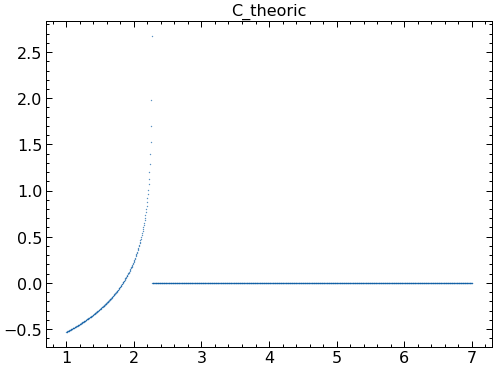

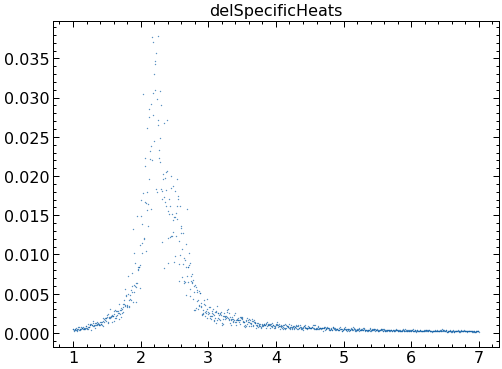

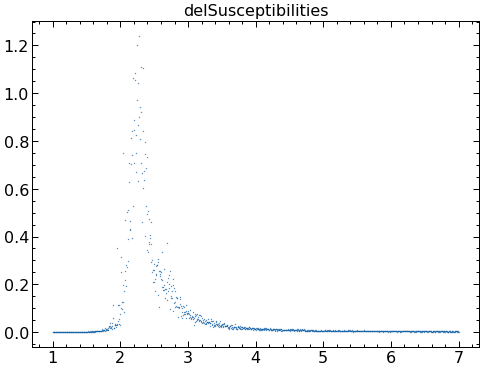

In [ ]:
plt.figure()
plt.scatter(T,Energies,s=0.1)
plt.title('Energies')

plt.figure()
plt.scatter(T,Magnetizations,s=0.1)
plt.title('Magnetizations')

plt.figure()
plt.scatter(T,SpecificHeats,s=0.1)
plt.title('SpecificHeats')

plt.figure()
plt.scatter(T,Susceptibilities,s=0.1)
plt.title('Susceptibilities')

plt.figure()
plt.scatter(T,delEnergies,s=0.1)
plt.title('delEnergies')

plt.figure()
plt.scatter(T,delMagnetizations,s=0.1)
plt.title('delMagnetizations')

plt.figure()
plt.scatter(T,M_theoric,s=0.1)
plt.title('M_theoric')

plt.figure()
plt.scatter(T,C_theoric,s=0.1)
plt.title('C_theoric')

plt.figure()
plt.scatter(T,delSpecificHeats,s=0.1)
plt.title('delSpecificHeats')

plt.figure()
plt.scatter(T,delSusceptibilities,s=0.1)
plt.title('delSusceptibilities')
